In [31]:
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver
from anytree import Node
from constants import μ, R, Q, k, c, G, H_int, ρ_int
from representations import render_tree, digraph_repr, drawfull, tree_incidence
from notation import graphs_from_incidence, make_acyclic, solvers_bottom_up, generate_execution, default_sequence
import numpy as np
import sympy as sp
import networkx as nx
from sympy.utilities.lambdify import implemented_function
import matplotlib.pyplot as plt
from collections import OrderedDict
from datastructures.graphutils import namefromsympy, flat_graph_formulation, Node, COMP, VAR, merge_edges, all_varnodes, all_variables, sources
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.execution import Component
from datastructures.workflow import order_from_tree, get_f, mdao_workflow, default_solver_options
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi
from executeformulations import extractvals
import pandas as pd
from datastructures.postprocess import print_values_static
from datastructures.rendering import render_incidence

# Sizing equations

## Parameters

In [2]:
dBtoLinear = lambda db: 10**(db/10)
D_r = Par('D_r', 5.3, 'm')
L = Par('L', dBtoLinear(1+8.5+0.3+0.1)) #based on SMAD page 567
T_s = Par('T_s', 135, 'K')
B = Par('B', 8, 'bit')
N = Par('N', 2e3, '')
eta = Par(r'\eta_c', 0.55)
l_v = Par('l_v', 500, 'nm')
f = Par('f', 2.2, 'GHz')
rho_T = Par(r'\rho_T', 500e3, 'kg*m')
rho_P = Par(r'\rho_P', 0.002e-3, 'kg/J')
P_l = Par('P_l', 12, 'W')
m_c = Par('m_c', 0.2, 'kg')
C_D = Par('C_D', 2.2)
I_sp = Par('Isp', 70, 's')
w_W = Par('w_W', 1000, 'rad/s')
c_W = Par('c_W', 1)
rho_M = Par(r'\rho_M', 11.4)
rho_P2 = Par(r'\rho_P2', 9/0.1)
M_B = Par('M_B', 7.96e15)
kp = Par('kp', 0.0002)

In [41]:
model = Model()
m = model.root

## Orbit / mission design

In [42]:
orbit = addsolver(m, name='orbit')

In [43]:
h = Var('h', 400, 'km') #
a = adda(orbit, 'a', h + R, unit='km')
T = adda(orbit, 'T', 2*np.pi*(a**3/μ)**0.5, unit='min')
g = adda(orbit, 'g', 1/np.pi*sp.acos(R/a), unit='')
d = adda(orbit, 'd', g+0.5)
r = adda(orbit, 'r', (h**2+2*R*h)**0.5, unit='km')

## Power

In [44]:
power = addsolver(m, name='power')

In [45]:
eta_A = Par(r'\eta_A', 0.3)
rho_A = Par(r'\rho_A', 10, 'kg/m^2') #
#ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
A = Var('A', 0.05, unit='m^2')
m_A = adda(power, 'm_A', rho_A*A, unit='g')
P_c = adda(power, 'P_c', d*A*Q*eta_A, unit='W')
P_T = adda(power, 'P_T', P_c-P_l, unit='W') #hack
E_b = adda(power, 'E_b', P_c*T/d, unit='kJ')
rho_b = Par(r'\rho_b', 0.002, 'kg/kJ')
m_b = adda(power, 'm_b', rho_b*E_b, unit='g')
#E_b, m_b = E_bi[bat], m_bi[bat]

## Payload

In [46]:
payload = addsolver(m, name='payload')

In [47]:
X_r = Var('X_r', 5, 'm')
D_p = adda(payload, 'D_p', 1.22*l_v*h/X_r)
D = adda(payload, 'D', 2*np.pi*R*B*N/X_r, unit='GB')
rho_p = Par(r'\rho_p', 2, 'kg/m^1.5') 
#D_p, m_p = D_pi[payload], m_pi[payload]
m_p = adda(payload, 'm_p', rho_p*D_p**1.5, unit='g')

In [48]:
#payload = addsolver(m, geteqs(m, [D_p, D, m_p]), [], name='payload')

## Comms

In [49]:
comms = addsolver(m, name='comms')

In [50]:
b = adda(comms, 'b', D/T, unit='MB/s')
λ_c = adda(comms, r'\lambda_c', c/f, unit='cm')
G_T = Par('G_T', dBtoLinear(16.5), '')
D_T = adda(comms, 'D_T', λ_c*(G_T/eta)**0.5/np.pi, unit='m')
rho_T = Par(r'\rho_T', 0.2, 'kg/m^1.5')
m_T = adda(comms, 'm_T', rho_T*D_T**1.5, unit='g')
#m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
G_r = adda(comms, 'G_r', eta*(np.pi*D_r/λ_c)**2)
EN = adda(comms, 'EN', P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2, unit='')

In [51]:
#comms = addsolver(m, geteqs(m, [b, λ_c, D_T, m_T, G_r, EN]), [], name='comms')

## Mass and struct

In [52]:
struct = addsolver(m, name='struct')
mt = Var('m_t', unit='kg')
eta_S = Par(r'\eta_S', 0.2)
m_s = adda(struct, 'm_s', eta_S*mt, unit='g')

In [53]:
mass = addsolver(m, name='mass')
adda(mass, mt, m_T+m_p+m_b+m_A+m_s)

m_t

In [54]:
# struct = addsolver(m, geteqs(m, [m_s]), [], name='struct')
# mass = addsolver(m, geteqs(m, [mt]), [], name='mass')

## Propulsion

In [55]:
prop = addsolver(m, name='prop')

In [56]:
H = implemented_function(sp.Function('H'), H_int)
rho = implemented_function(sp.Function('rho'),  ρ_int)

In [57]:
L_min = Var('L_{min}', 5, 'yr')
m_pr = Var('m_{pr}', 0.5, unit='kg')
Hval = adda(prop, 'H_{val}', H(h*1e3), unit='m', forceunit=True)
rhoval= adda(prop, r'\rho_{val}', rho(h*1e3), unit='kg/m**3', forceunit=True)
Ln = adda(prop, 'L_n', Hval*mt/(2*np.pi*C_D*A*rhoval*a**2)*T, unit='yr')
Lp = adda(prop, 'L_p', m_pr*I_sp*G*a/(0.5*C_D*A*rhoval*μ), unit='yr')
Lt = adda(prop, 'L_t', Ln+Lp, unit='yr')

# Run

In [58]:
edges, tree = model.generate_formulation()

In [61]:
DG = flat_graph_formulation(*edges)
#merge_order = sort_scc(DG)
#nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)
# to use this we also need to create residual components!

In [62]:
#components = [Component.fromsympy(right, tovar=left, component=key) for key,(left,right) in eqs.items()]
#components += [Component.fromsympy(left-right, component=key, tovar=left if not left.forceunit else None, ignoretovar=True) for key,(left,right) in eqs.items()]

In [22]:
# for now we are not using the generated ordering
ordered_tree = tree 
ordered_edges = edges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1] = {'solver': 'GS', 'maxiter':20} #without derivatives
nodetyperepr = model.nametyperepr
namingfunc = namefromsympy(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [23]:
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [24]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [25]:
prob.run_model()


==
s1
==
NL: NLBGS Converged in 9 iterations


# Results

In [26]:
from datastructures.postprocess import print_outputs, print_inputs

In [27]:
print_inputs(model, prob, namingfunc, mdao_in, False, False)

,0,1,2
0,$$k$$,1.381×10⁻²³,J/K
1,$$\eta_c$$,0.55,
2,$$\rho_A$$,10,kg/m²
3,$$\eta_S$$,0.2,
4,$$N$$,2000,
5,$$\rho_b$$,0.002,kg/kJ
6,$$Isp$$,70,s
7,$$D_r$$,5.3,m
8,$$C_D$$,2.2,
9,$$P_l$$,12,W


In [28]:
print_outputs(model, prob, namingfunc, display=False)

,0,1,2
0,$$a$$,6778,km
1,$$T$$,92.558,min
2,$$g$$,0.11,
3,$$d$$,0.61,
4,$$r$$,2293.992,km
5,$$m_A$$,500,g
6,$$P_c$$,12.506,W
7,$$P_T$$,0.506,W
8,$$E_b$$,113.874,kJ
9,$$m_b$$,227.747,g


# Visualize structure

In [63]:
Ein, Eout, Rin = edges
Ein_noparam = {comp:tuple(var for var in compvars if not model.idmapping[var].always_input) for comp,compvars in Ein.items()}
edges_noparam = Ein_noparam, Eout, Rin

In [66]:
from datastructures.graphutils import SOLVER, namefromid, copy_dicts
nodetyperepr2 = {VAR: '{}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc2 = namefromid(nodetyperepr2)

In [73]:
tree2 = copy_dicts(tree)
tree2[1].update({6: 9, 7: 9, 9:1})

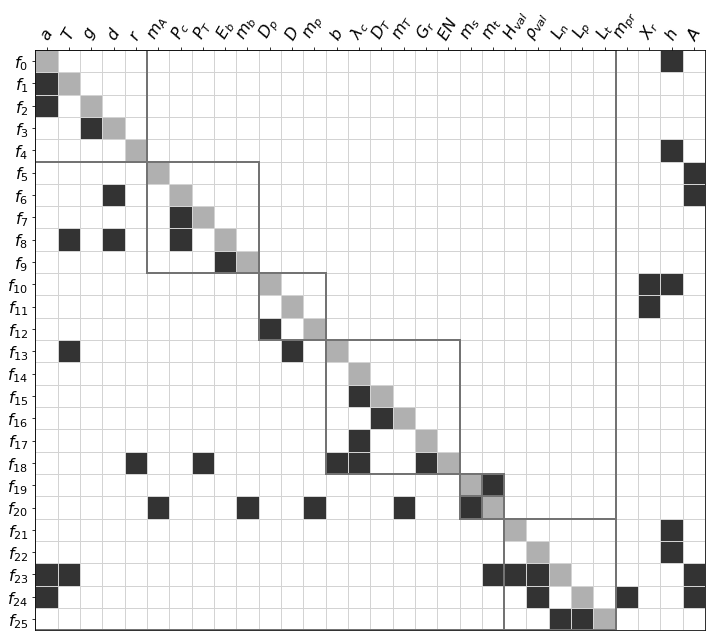

In [74]:
_, ax = render_incidence(edges_noparam, tree2, namingfunc2, figsize=(12,12))

### Tree & Graph

In [92]:
from datastructures.nestedgraph import build_typedgraph
from datastructures.graphutils import draw_graph_graphical_props, all_solvers

In [90]:
from collections import defaultdict

In [108]:
graphs = build_typedgraph(edges, tree, nodetyperepr2)

In [156]:
Ein = defaultdict(list)
Eout = defaultdict(list)
Eout2 = dict()
solvers = all_solvers(tree2)
for key,var in graphs[1].edges():
    if key.name in solvers:
        Eout[key.name].append(var.name)
    else:
        Ein[var.name].append(key.name)
Eout2 = dict({idx:(idx,) for idx in range(2,9)})
for comp,varnames in Ein.items():
    Ein2[comp] = tuple(set(outcomp for var in varnames for outcomp,outvar in Eout.items() if var in outvar))
nodetyperepr3 = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}
namingfunc3 = namefromid(nodetyperepr3)

In [161]:
tree3 = OrderedDict([(elt,1) for elt in range(2,9)])
tree3[6] = 9
tree3[7] = 9

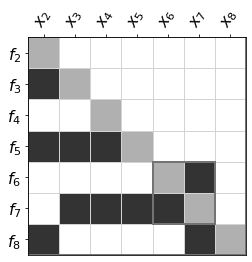

In [163]:
_, ax = render_incidence((Ein2, Eout2, dict()), (tree3,{9:1},dict()), namingfunc3)

In [104]:
Ein

defaultdict(list,
            {9: [m_A, m_b, m_T, m_p],
             8: [m_t, a, A, h, \mu, T],
             3: [A, T, d],
             4: [h, R],
             2: [h, \mu, R],
             5: [T, r, D, P_T]})

In [89]:
graphs[1].edges()

OutEdgeView([(m_A, 9), (9, m_t), (m_b, 9), (m_T, 9), (m_p, 9), (m_t, 8), (a, 8), (A, 8), (A, 3), (h, 8), (h, 4), (h, 2), (\mu, 8), (\mu, 2), (T, 8), (T, 5), (T, 3), (r, 5), (5, m_T), (D, 5), (P_T, 5), (R, 4), (R, 2), (4, D), (4, m_p), (3, m_A), (3, m_b), (3, P_T), (d, 3), (2, r), (2, T), (2, a), (2, d)])

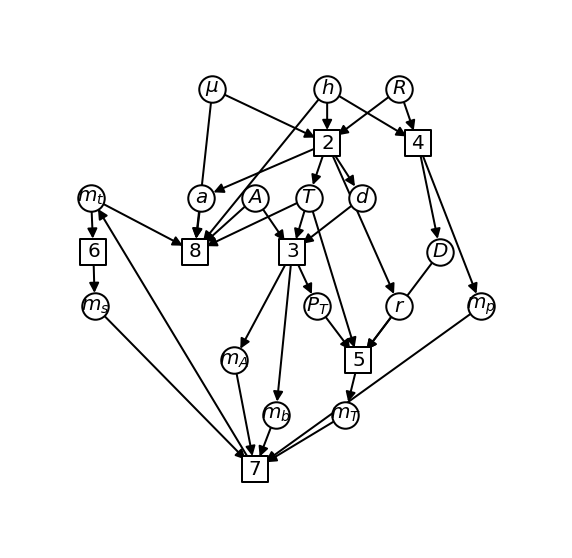

In [168]:
draw_graph_graphical_props(graphs[1], {}, prog='dot', figsize=(10,10))

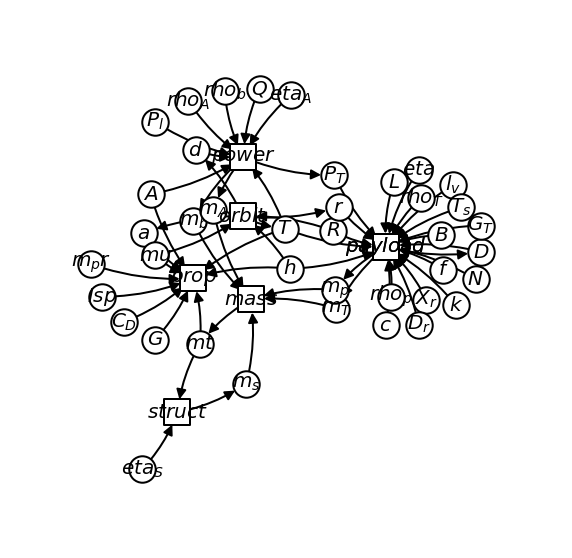

In [19]:
drawfull(graphs[m], model.eqs, figsize=(10,10))